In [4]:
from math import sqrt
import matplotlib.pyplot as plt

import torch
import Steerable.nn as snn
from Steerable.utils import rotate_image2D, rotate_image3D

# Gaussian Noise Dataset

In [2]:
class GaussianDataset(torch.utils.data.Dataset):
    def __init__(self, shape, mean=0.0, std=1.0, size=1000):
        self.mean = mean
        self.std = std
        self.shape = shape
        self.size = size

    def __getitem__(self, idx):
        if idx >= self.size:
            raise ValueError(f'Index{idx} out of range for dataset of size {self.size}')
        image = torch.randn(self.shape) * self.std + self.mean
        label = None
        return image, label

    def __len__(self):
        return self.size

# Function to Check Equivariance

In [3]:
def check_equivariance(model, dataset, transfomation=None):
    device = next(model.parameters()).device
    def diff_output(inputs1, inputs2):
        with torch.no_grad():
            outputs1 = model(inputs1.unsqueeze(0).to(device))[0]
            outputs2 = model(inputs2.unsqueeze(0).to(device))[0]
            diff_norm = torch.linalg.vector_norm(outputs1-outputs2)
            norm1 = torch.linalg.vector_norm(outputs1)
            norm2 = torch.linalg.vector_norm(outputs1)
            return (diff_norm/sqrt(norm1*norm2)).item() * 100
        
    degrees = torch.arange(0, 361, 90)
    values = torch.zeros(len(dataset), len(degrees))
    
    for i in range(len(dataset)):
        inputs, _ = dataset[i]
        with torch.no_grad():
            for parameters in model.parameters():
                parameters.copy_(torch.randn_like(parameters))
            for j in range(len(degrees)):
                inputs_rot = transfomation(inputs, degrees[j]) if transfomation else inputs
                values[i, j] = diff_output(inputs, inputs_rot)

        print(f'Simulation : {i+1} / {len(dataset)}', end='\r')

    diff_mean = values.mean(dim=0)
    diff_std = values.std(dim=0)

    plt.plot(degrees, diff_mean)
    plt.fill_between(degrees, diff_mean-1.95*diff_std/sqrt(len(dataset)),  diff_mean+1.95*diff_std/sqrt(len(dataset)), color='blue', alpha=0.2)
    plt.xticks([45*i for i in range(degrees.max().item()//45 + 1)])
    for intercept in [90*i+45 for i in range(round(degrees.max().item()/90))]:
        plt.axvline(intercept, linestyle='dashed', color='red')
    plt.xlabel('Degree', size=15)
    plt.ylabel('Error %',size=15)
    plt.show()

# Two Dimension

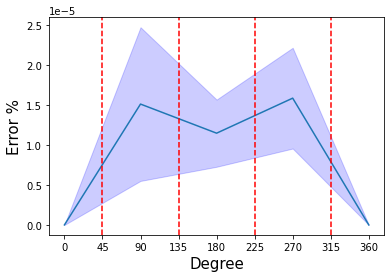

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Model
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        freq_cutoff = 4
        n_angle = 32
        interpolation_type = 0

        self.network = torch.nn.Sequential(
            snn.SE2ConvType1(1, 2, 5, freq_cutoff, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            snn.SE2CGNonLinearity(2, freq_cutoff, n_angle),
            snn.SE2BatchNorm(),
            snn.SE2ConvType2(2, 2, 5, freq_cutoff, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            
            snn.SE2AvgPool(4),
            
            snn.SE2ConvType2(2, 2, 7,freq_cutoff, n_angle=n_angle, interpolation_type=interpolation_type),
            snn.SE2NormFlatten()
        )

    def forward(self,x):
        return self.network(x.type(torch.cfloat))

# Check Equivariance
model = Model().to(device)
dataset = GaussianDataset(shape=(1,28,28), size=10)
check_equivariance(model, dataset, lambda x, degree:rotate_image2D(x, degree))

# Three Dimension

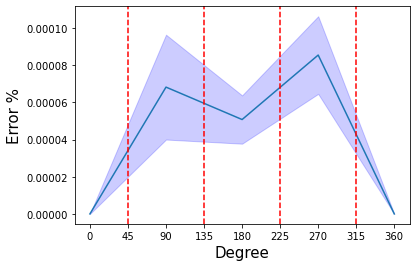

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Model
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        n_angle = 40
        interpolation_type = -1
        
        self.network = torch.nn.Sequential(
            snn.SE3Conv(1, [2,3], 5, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            snn.SE3NormNonLinearity([2,3]),
            snn.SE3Conv([2,3], [4,5], 5, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            snn.SE3BatchNorm(),
            
            snn.SE3AvgPool(4),
            
            snn.SE3Conv([4, 5], [4, 5], 8, n_angle=n_angle, interpolation_type=interpolation_type),
            snn.SE3NormFlatten()
        )
    def forward(self,x):
        return self.network(x.type(torch.cfloat))
    
# Check Equivariance
model = Model().to(device)
dataset = GaussianDataset(shape=(1,32,32,32), size=3)
check_equivariance(model, dataset, lambda x, degree:rotate_image3D(x, (degree,0,0))) # rotation about z-axis
#check_equivariance(model, dataset, lambda x, degree:snn.rotate_image(x, (0,degree,0))) # rotation about y-axis